# Did Tico manatee swim or surf the North Brazil Current?

In this notebook, we will explore the Tico manatee location data and compare this data with surface currents estimated by OSCAR. 

We also intend to perform a similar analysis to a GDP surface drifter that was in the region at the same time to prove that Tico did not swim to Venezuela, but was carried by the currents.

## Import modules and load GPS data 

In [160]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import pandas as pd
import numpy as np
from dateparser import parse
import cmcrameri.cm as cmc
from tqdm import tqdm

In [14]:
# load data
df = pd.read_csv("../data/planilhaSateliteTicoR4.csv", delimiter=";")
df = df.rename(columns={"Classe Argos":"Class"})
df = df[~df["Class"].apply(lambda c: ("Uncertain" in c)|("Unresolved" in c))]

# parse timestamps
time = (df["Data"]+" "+df["Hora"]).apply(parse)

# set index
df = df[["Longitude","Latitude","Class"]]
df.index = time
df.index.name = "time"

ds = df.to_xarray()
ds = ds.assign(x = 111.32e3 * np.cos(np.deg2rad(ds.Latitude)) * ds.Longitude,y = 110.574e3 * ds.Latitude)
ds = ds.assign(x = ds.x-ds.x.isel(time=0), y = ds.y-ds.y.isel(time=0))
ds = ds.sortby("time")


Plotting positions separated by each ARGO class.

Error estimates:
 - **G (GPS):** 5 m
 - **Q / QFP (GPS corrected):** 5 to 500 m
 - **3 (Argos):** < 250 m
 - **2 (Argos):** 250 to 500 m
 - **1 (Argos):** 500 to 1500 m
 - **0 (Argos):** > 1500 m

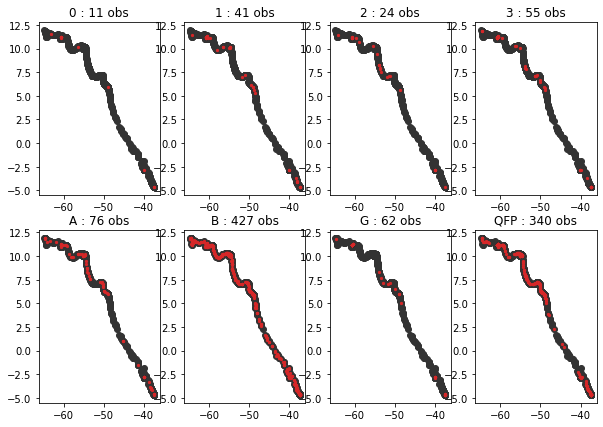

In [15]:
classes = np.unique(ds.Class)
fig,ax = plt.subplots(2, classes.size//2, figsize=(10,7))
ax = np.ravel(ax)
for i,c in enumerate(classes):
    ds.plot.scatter("Longitude","Latitude", ax=ax[i], color="0.2")
    ds.where(ds.Class==c).plot.scatter("Longitude","Latitude", ax=ax[i], color="tab:red", s=5)
    ax[i].set(title=f"{c} : {(ds.Class==c).sum().values} obs", xlabel="", ylabel="")


Taking a conservative approach, we will keep only the G and Q classes for future analysis.

Thus, we estimate the geographic positions in meters and obtain the Tico velocity through the time derivative of the positions.

In [16]:
ds = ds.where((ds.Class=="QFP")|(ds.Class=="G"), drop=True)
ds = ds.assign(u = ds.x.differentiate("time", datetime_unit="s"), v = ds.y.differentiate("time", datetime_unit="s"))
ds = ds.assign(spd = np.sqrt(ds.u**2 + ds.v**2))


The magnitude of the velocities match the expected values for the currents in the region.

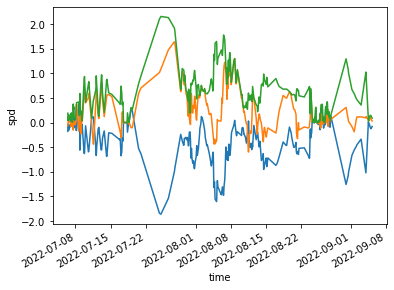

In [17]:
ds.u.plot()
ds.v.plot()
ds.spd.plot()


## Load GEBCO bathymetry and OSCAR surface currents data

Now we load the GEBCO bathymetry data and OSCAR surface currents. The OSCAR data needed to be preprocessed to interpret timestamps, change reference longitudes, transpose coordinates to facilitate plots, and calculate velocity magnitude.

In [209]:
# load bathymetry
bat = xr.open_dataset("../data/gebco_2022_n21.4673_s-7.4048_w-68.6426_e-32.7393.nc").elevation
bat = bat.sel(lat=slice(-7.5,15,10), lon=slice(-66,-30,10))
ds = ds.assign(local_depth = bat.interp(lat = ds.Latitude, lon = ds.Longitude).drop(["lat","lon"]))

oscar = xr.open_mfdataset("../data/OSCAR_L4_OC_NRT_V2.0/*.nc")
oscar = oscar.assign_coords(time=[parse(time.strftime()) for time in oscar.time.values])
oscar = oscar.assign_coords(lon=(((oscar.lon + 180) % 360) - 180))
oscar = oscar.rename(lon="longitude", lat="latitude")
oscar = oscar.assign_coords(longitude=oscar.longitude, latitude=oscar.latitude)
oscar = oscar[["u","v"]].sel(latitude=slice(-7.4,15), longitude=slice(-66,-30))
oscar = oscar.transpose("latitude","longitude","time")
oscar = oscar.assign(spd=np.sqrt(oscar.u**2 + oscar.v**2))


## Plot maps for trajectory and ocean currents

We will now make a figure of the Tico trajectory by superimposing the average current field for the entire period. As the period is very long, the trajectory does not necessarily match the current field presented. In this map, we add markers for every 7 days of the trajectory to provide a temporal variation.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


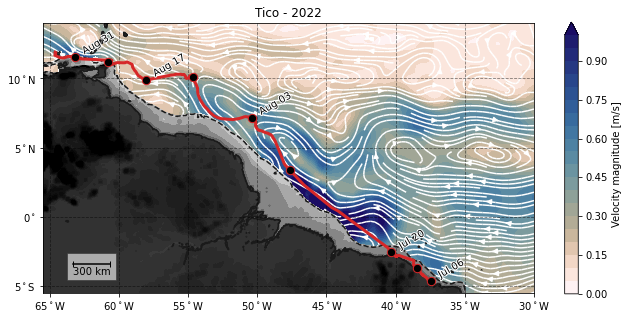

In [350]:
fig, ax = plt.subplots(figsize=(11,5))

C = np.sqrt(oscar.u**2 + oscar.v**2).mean("time").plot.contourf(levels=np.arange(0,1.05,0.05), cmap=cmc.lapaz_r, vmin=-0.05, vmax=1, add_colorbar=False, zorder=0)
[a.set_edgecolor("face") for a in C.collections]
oscar.mean("time").plot.streamplot("longitude", "latitude", "u", "v", color=(1,1,1,1), density=2.5,zorder=0)
fig.colorbar(C, label="Velocity magnitude [m/s]")


ax.plot(ds.Longitude, ds.Latitude, color="tab:red", linewidth=3, zorder=2)

dsw = ds.interp(time=pd.date_range(start=ds.time.min().values, end=ds.time.max().values, freq="7d"))
dsw.plot.scatter("Longitude", "Latitude", zorder=2, edgecolor="tab:red", color="k", s=70)

for i in np.arange(0,dsw.time.size,2):
    loni = dsw.isel(time=i).Longitude.values
    lati = dsw.isel(time=i).Latitude.values
    ti = pd.to_datetime(str(dsw.isel(time=i).time.values))
    text = ax.text(loni,lati,ti.strftime('  %b %d'), rotation=30)
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                       path_effects.Normal()])
    
C = bat.rolling(lon=5,lat=5).mean().where((bat>-200)&(bat<0)).plot.contourf(levels=10, vmin=-200, vmax=100, cmap="Greys", extend="max", zorder=1, add_colorbar=False)
[a.set_edgecolor("face") for a in C.collections]
C = bat.rolling(lon=5,lat=5).mean().where(bat>0).plot.contourf(levels=50, vmin=-4000, vmax=800, cmap="Greys", extend="max", zorder=1, add_colorbar=False)
[a.set_edgecolor("face") for a in C.collections]
bat.plot.contour(levels=[-150,0], colors=["0.1"], extend="neither", add_colorbar=False, zorder=1)




lni,lti = -62,-3.4
ref = 300#km
ax.plot([lni-ref/2/111.3,lni+ref/2/111.3],[lti,lti],marker="|", color="k")
ax.text(lni,lti-0.2,f"{ref} km",ha="center",va="top")
height = 2
rectangle = plt.Rectangle((lni-1.3*ref/2/111.3,lti-0.6*height), 1.3*ref/111.3, height, fc='w',ec="0.2", alpha=0.6)
plt.gca().add_patch(rectangle)


lablat = lambda lat: f'{lat}$^\\circ$' if lat==0 else f'{lat}$^\\circ$N' if lat>0 else f'{-lat}$^\\circ$S'
lablon = lambda lat: f'{lat}$^\\circ$' if lat==0 else f'{lat}$^\\circ$E' if lat>0 else f'{-lat}$^\\circ$W'

xticks = np.arange(-180,180,5)
yticks = np.arange(-90,90,5)

ax.axis("scaled")
ax.grid(True, linestyle="--",zorder=3, alpha=0.5, color="0.0")
_ = ax.set(
    ylabel='',
    xlabel='',
    xticks=xticks,
    yticks=yticks,
    xticklabels=list(map(lablon,xticks)),
    yticklabels=list(map(lablat,yticks)),
    xlim=[-65.5,-30],
    ylim=[-5.5,14],
    title=f"Tico - {ds.time.dt.year.values[0]}"
)

fig.savefig("../img/map_trajectory.pdf", dpi=300, facecolor="w", bbox_inches="tight")
fig.savefig("../img/map_trajectory.eps", dpi=300, facecolor="w", bbox_inches="tight")
fig.savefig("../img/map_trajectory.png", dpi=300, facecolor="w", bbox_inches="tight")


In a better representation, we present average fields for each 10-day trajectory, showing only the positions of the G and Q classes. Due to a shorter average, the trajectory better follows the current patterns. We plan to add a link to a video to make the trajectory easier to watch.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


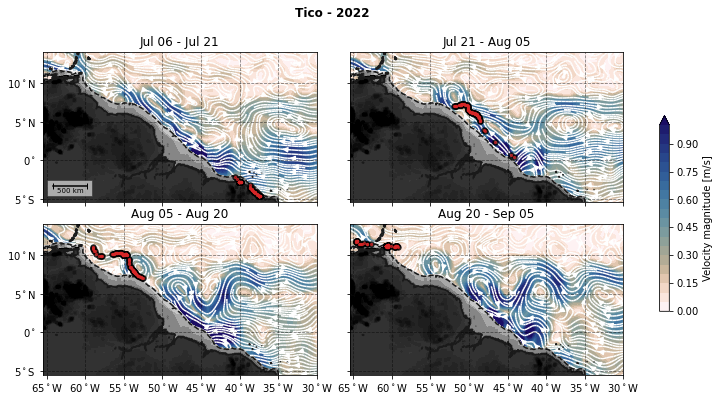

In [351]:
timei = pd.date_range(start=ds.time.min().values, end=ds.time.max().values, freq="1d")[::15][:-1].astype("str")

lablat = lambda lat: f'{lat}$^\\circ$' if lat==0 else f'{lat}$^\\circ$N' if lat>0 else f'{-lat}$^\\circ$S'
lablon = lambda lat: f'{lat}$^\\circ$' if lat==0 else f'{lat}$^\\circ$E' if lat>0 else f'{-lat}$^\\circ$W'

xticks = np.arange(-180,180,5)
yticks = np.arange(-90,90,5)

fig, ax = plt.subplots(int(np.ceil(timei.size/2)),2, figsize=(13,6))
fig.subplots_adjust(hspace=0.12, wspace=0.12)
ax = np.ravel(ax)
for ti,tj,a in zip(timei, timei[1:].tolist()+[ds.time.max().values], ax):
    ds.sel(time=slice(ti,tj)).plot.scatter("Longitude","Latitude", s=30, color="k", ax=a, zorder=2, alpha=0.7)
    ds.sel(time=slice(ti,tj)).plot.scatter("Longitude","Latitude", s=5, color="tab:red", ax=a, zorder=2, alpha=0.7)
    
    C = bat.rolling(lon=5,lat=5).mean().where((bat>-200)&(bat<0)).plot.contourf(ax=a,levels=10, vmin=-200, vmax=100, cmap="Greys", extend="max", zorder=1, add_colorbar=False)
    [ci.set_edgecolor("face") for ci in C.collections]
    C = bat.rolling(lon=5,lat=5).mean().where(bat>0).plot.contourf(ax=a,levels=50, vmin=-4000, vmax=800, cmap="Greys", extend="max", zorder=1, add_colorbar=False)
    [ci.set_edgecolor("face") for ci in C.collections]
    bat.plot.contour(ax=a,levels=[-150,0], colors=["0.1"], extend="neither", add_colorbar=False, zorder=1)
    
    oscari = oscar.sel(time=slice(ti,tj)).mean("time")
    C = np.sqrt(oscari.u**2 + oscari.v**2).plot.contourf(ax=a, levels=np.arange(0,1.05,0.05), cmap=cmc.lapaz_r, vmin=-0.05, vmax=1, add_colorbar=False, zorder=0)
    [ci.set_edgecolor("face") for ci in C.collections]
    oscari.plot.streamplot("longitude", "latitude", "u", "v", ax=a, color=(1,1,1,1), density=2.5,zorder=0)
    
    a.axis("scaled")
    a.grid(True, linestyle="--",zorder=3, alpha=0.5, color="0.0")
    _ = a.set(
        ylabel='',
        xlabel='',
        xticks=xticks,
        yticks=yticks,
        xticklabels=list(map(lablon,xticks)),
        yticklabels=list(map(lablat,yticks)),
        xlim=[-65.5,-30],
        ylim=[-5.5,14],
        title=pd.to_datetime(ti).strftime("%b %d")+" - "+pd.to_datetime(tj).strftime("%b %d"),
    )
    
_ = [a.set(xticklabels=[]) for a in ax[:2]]
_ = [a.set(yticklabels=[]) for a in ax[1::2]]
fig.suptitle(f"Tico - {ds.time.dt.year.values[0]}"+30*" ", fontweight="bold")
fig.colorbar(C, ax=ax, label="Velocity magnitude [m/s]", shrink=0.6)


lni,lti = -62,-3.4
ref = 500#km
ax[0].plot([lni-ref/2/111.3,lni+ref/2/111.3],[lti,lti],marker="|", color="k", zorder=4)
ax[0].text(lni,lti-0.2,f"{ref} km",ha="center",va="top", zorder=4, fontsize=7)
height = 2
rectangle = plt.Rectangle((lni-1.3*ref/2/111.3,lti-0.6*height), 1.3*ref/111.3, height, fc='w',ec="0.2", alpha=0.6, zorder=3)
ax[0].add_patch(rectangle)


fig.savefig("../img/maps_trajectory.pdf", dpi=300, facecolor="w", bbox_inches="tight")
fig.savefig("../img/maps_trajectory.eps", dpi=300, facecolor="w", bbox_inches="tight")
fig.savefig("../img/maps_trajectory.png", dpi=300, facecolor="w", bbox_inches="tight")